In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [2]:

# Load and preprocess data
def load_and_preprocess_data(folder):
    dfs = []
    for i in range(9, 16):
        file_name = f"HTOL-{i:02d}_alerts.csv"
        df = pd.read_csv(os.path.join(folder, file_name))
        df['machine_id'] = f'HTOL-{i:02d}'
        dfs.append(df)

    combined_df = pd.concat(dfs, ignore_index=True)
    combined_df['Time'] = pd.to_datetime(combined_df['Time'])
    combined_df = combined_df.sort_values(['machine_id', 'Time'])

    return combined_df

In [3]:

# Feature engineering
def engineer_features(df):
    df['hour'] = df['Time'].dt.hour
    df['day_of_week'] = df['Time'].dt.dayofweek
    df['month'] = df['Time'].dt.month
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)

    # Calculate rolling statistics
    df['rolling_mean'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).mean().reset_index(0, drop=True)
    df['rolling_std'] = df.groupby('machine_id')['ChlPrs'].rolling(window=24, min_periods=1).std().reset_index(0, drop=True)

    # Calculate time since last alert for each type
    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    for alert_type in alert_types:
        df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
        df[f'time_since_{alert_type}'] = df[f'time_since_{alert_type}'].dt.total_seconds() / 3600  # Convert to hours

    return df

In [4]:

def prepare_data_for_classification(df, target_alert_type, prediction_window):
    df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)

    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X = df[features]
    y = df['target'].fillna(0)  # Fill NaN with 0 (no alert)

    return X, y

In [5]:

def train_and_evaluate_classifier(X_train, X_test, y_train, y_test):

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X_train_scaled, y_train)

    y_pred = model.predict(X_test_scaled)
    print(classification_report(y_test, y_pred))

    return model, scaler

In [6]:
def visualize_alerts_test_set(df_test, model, scaler, target_alert_type, prediction_window, probability_threshold=0.7):
    features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']]
    X_test = df_test[features]
    X_test_scaled = scaler.transform(X_test)

    df_test['alert_probability'] = model.predict_proba(X_test_scaled)[:, 1]
    df_test['high_risk'] = df_test['alert_probability'] > probability_threshold

    machines = df_test['machine_id'].unique()
    n_machines = len(machines)

    fig, axes = plt.subplots(n_machines, 1, figsize=(20, 5 * n_machines), sharex=True)
    fig.suptitle(f'Actual Alerts vs High Risk Periods for {target_alert_type} Alerts (Test Set)', fontsize=16)

    for i, machine_id in enumerate(machines):
        ax = axes[i] if n_machines > 1 else axes
        machine_df = df_test[df_test['machine_id'] == machine_id]

        # Plot actual alerts
        alerts = machine_df[machine_df['ALERT'] == target_alert_type]
        ax.scatter(alerts['Time'], [0] * len(alerts), marker='o', s=100, label=f'Actual {target_alert_type} Alert', color='red')

        # Plot high-risk periods
        high_risk_periods = machine_df[machine_df['high_risk']]
        ax.scatter(high_risk_periods['Time'], [0] * len(high_risk_periods), marker='x', s=100, label=f'High Risk Period ({target_alert_type})', color='blue')

        ax.set_ylabel(machine_id, fontweight='bold')
        ax.set_yticks([])
        ax.grid(True, axis='x')

        if i == 0:
            ax.legend()

    plt.xlabel('Date')
    fig.tight_layout()
    plt.show()

/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df[f'time_since_{alert_type}'] = df.groupby('machine_id').apply(lambda x: x['Time'] - x[x['ALERT'] == alert_type]['Time'].shift(1)).reset_index(level=0, drop=True)
/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/670758071.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this w


Training model for LOW alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    530848
         1.0       0.97      0.16      0.27      1033

    accuracy                           1.00    531881
   macro avg       0.98      0.58      0.64    531881
weighted avg       1.00      1.00      1.00    531881



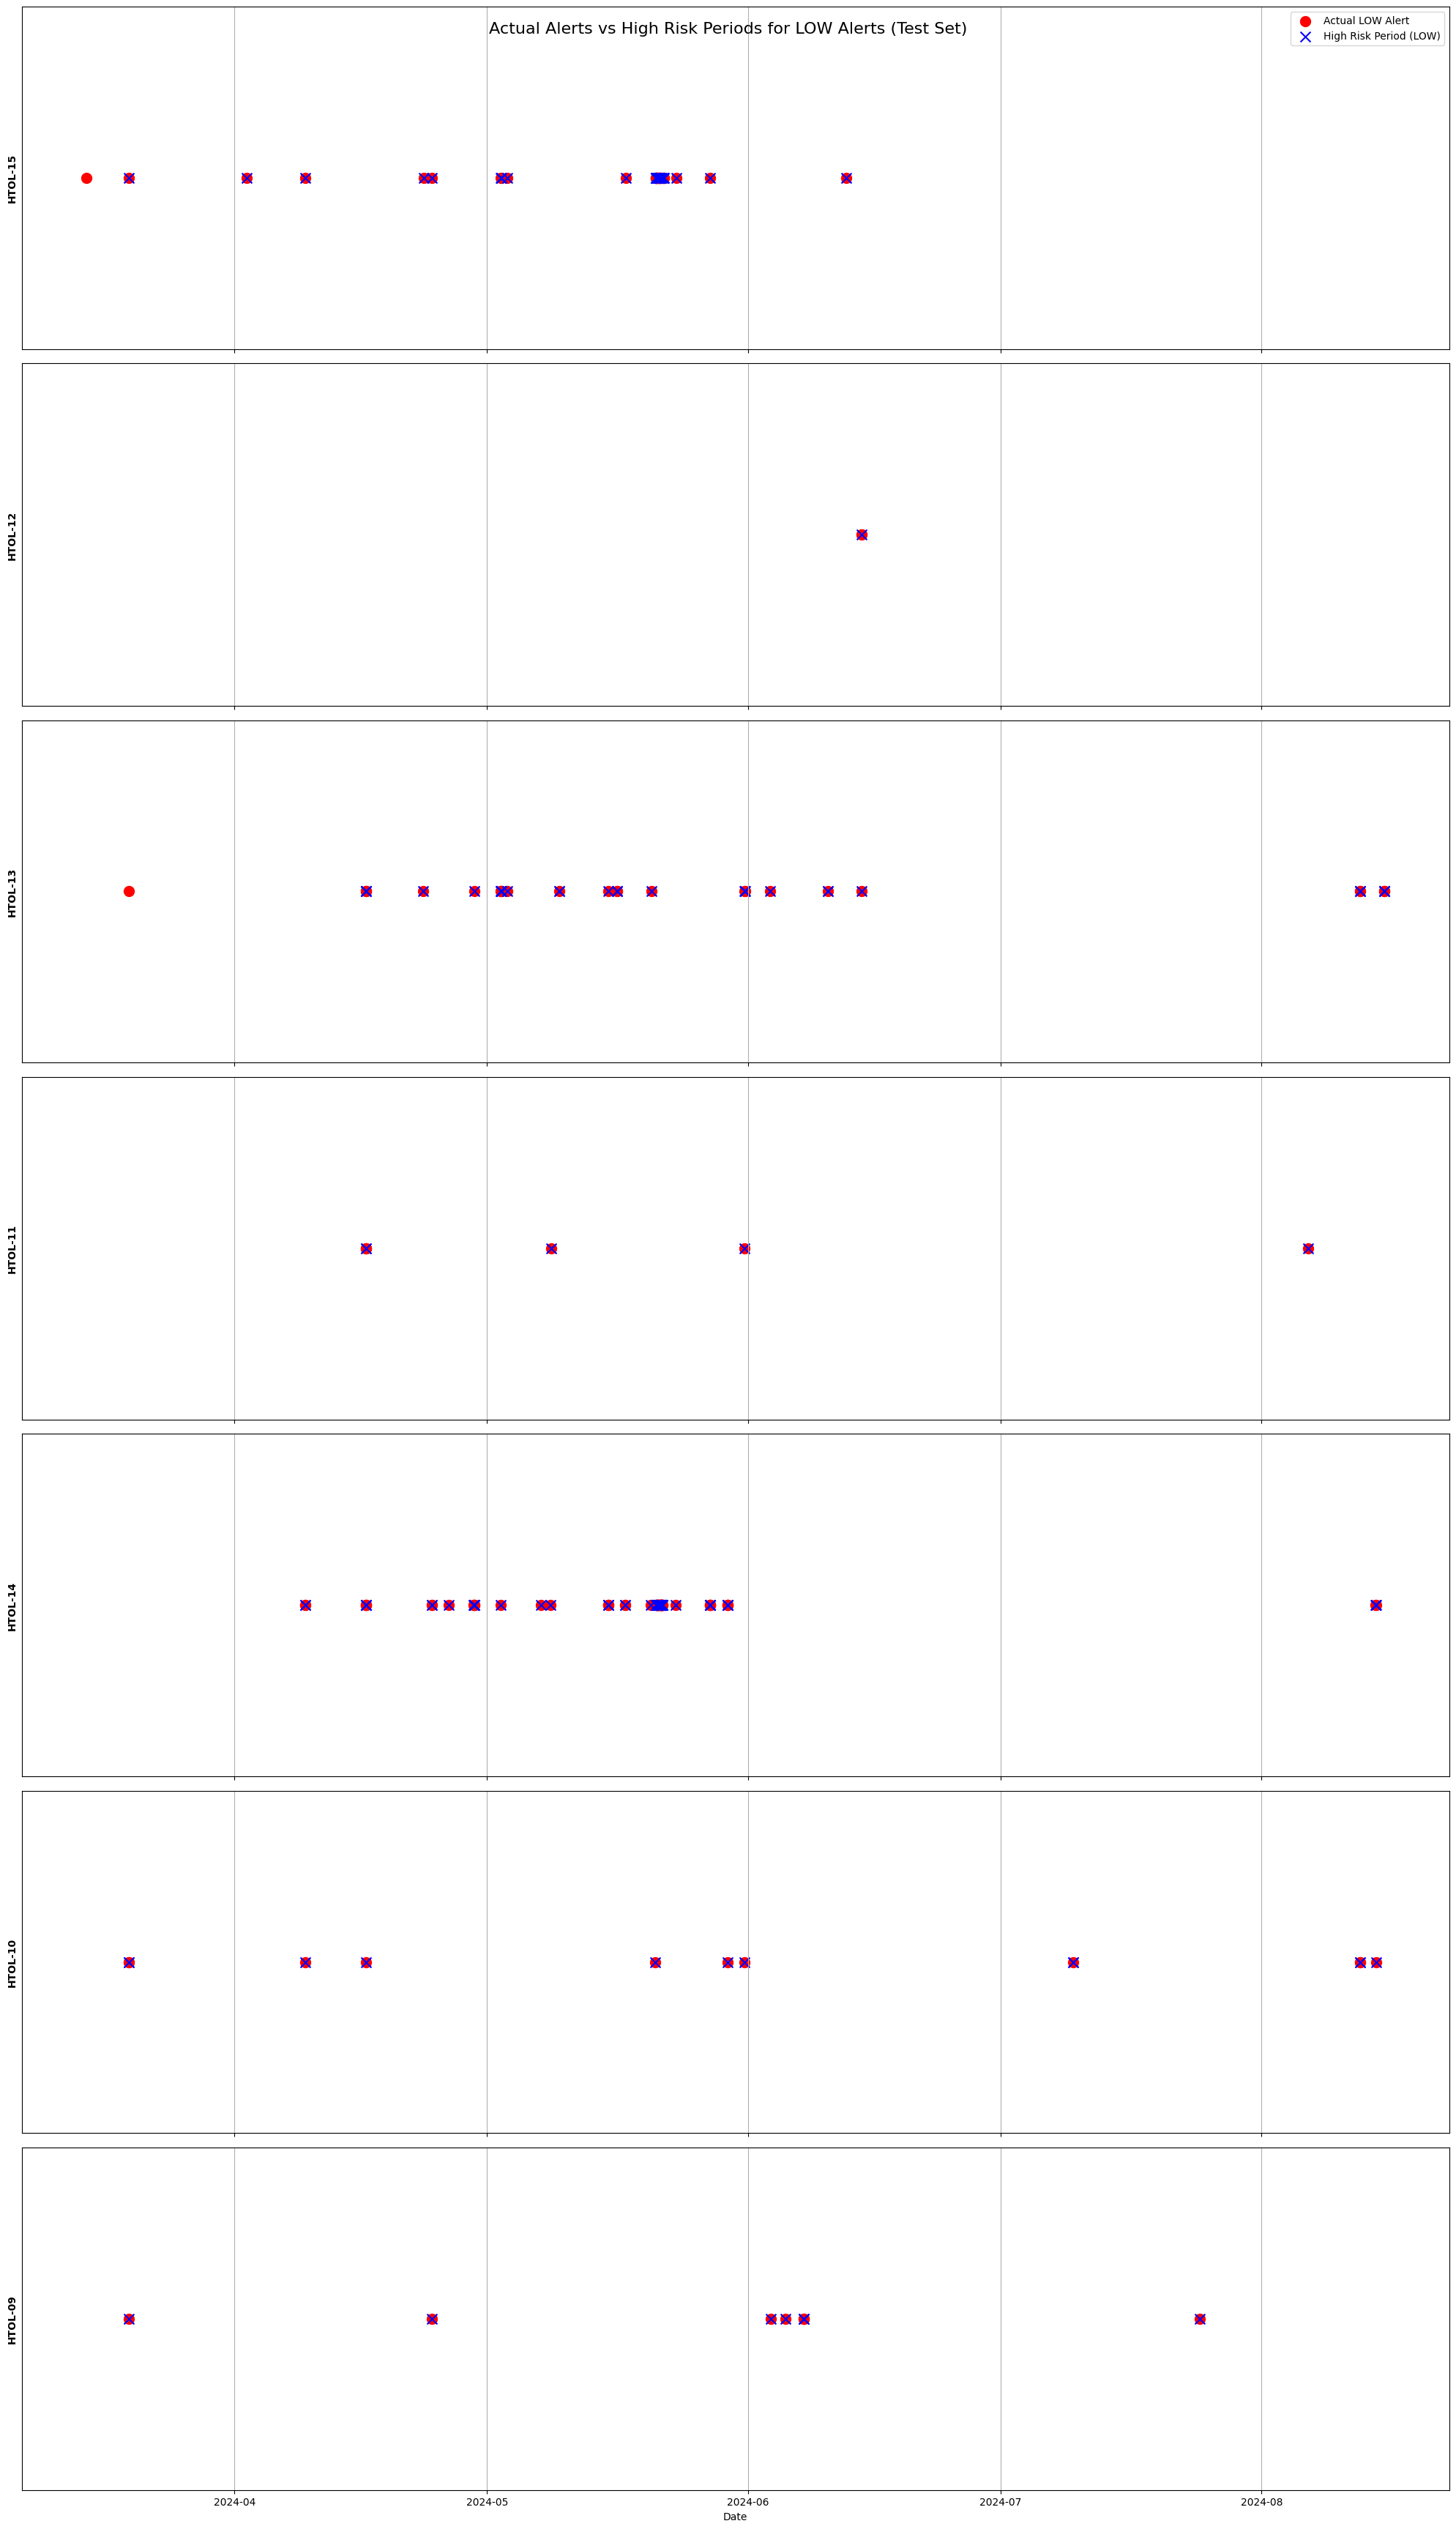


Training model for MEDIUM alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    531827
         1.0       0.95      0.39      0.55        54

    accuracy                           1.00    531881
   macro avg       0.98      0.69      0.78    531881
weighted avg       1.00      1.00      1.00    531881



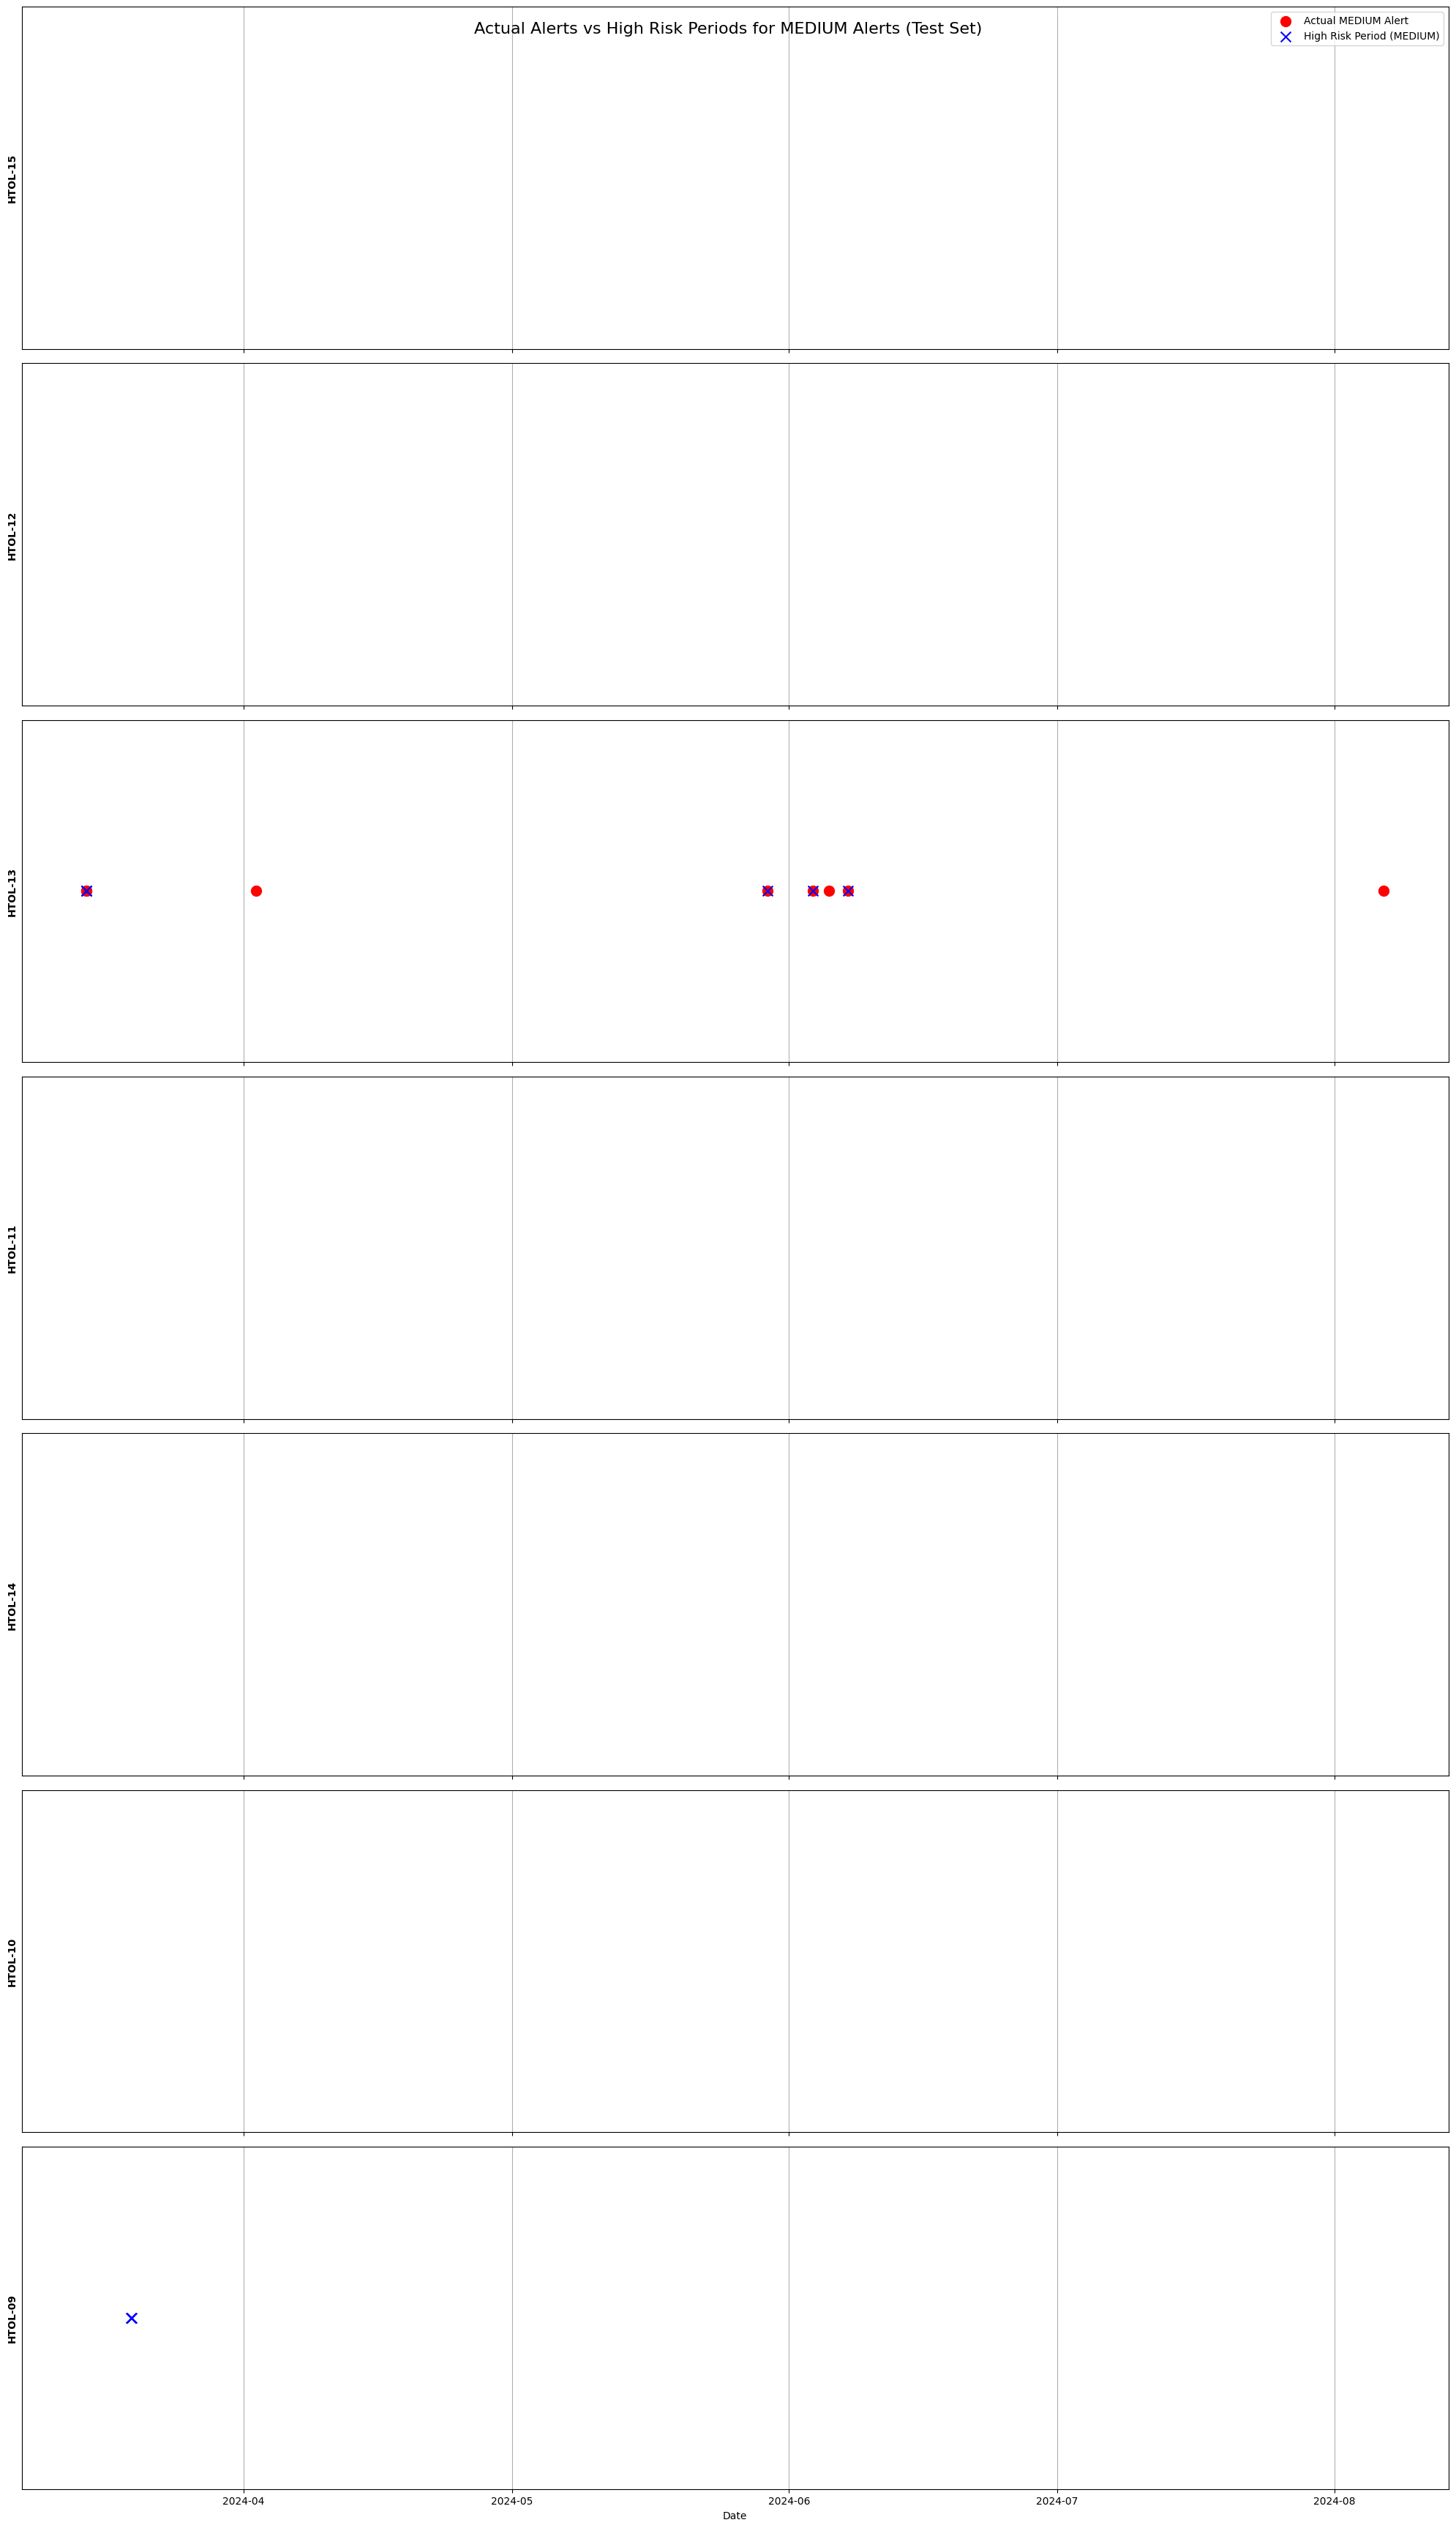


Training model for HIGH alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    531861
         1.0       0.86      0.30      0.44        20

    accuracy                           1.00    531881
   macro avg       0.93      0.65      0.72    531881
weighted avg       1.00      1.00      1.00    531881



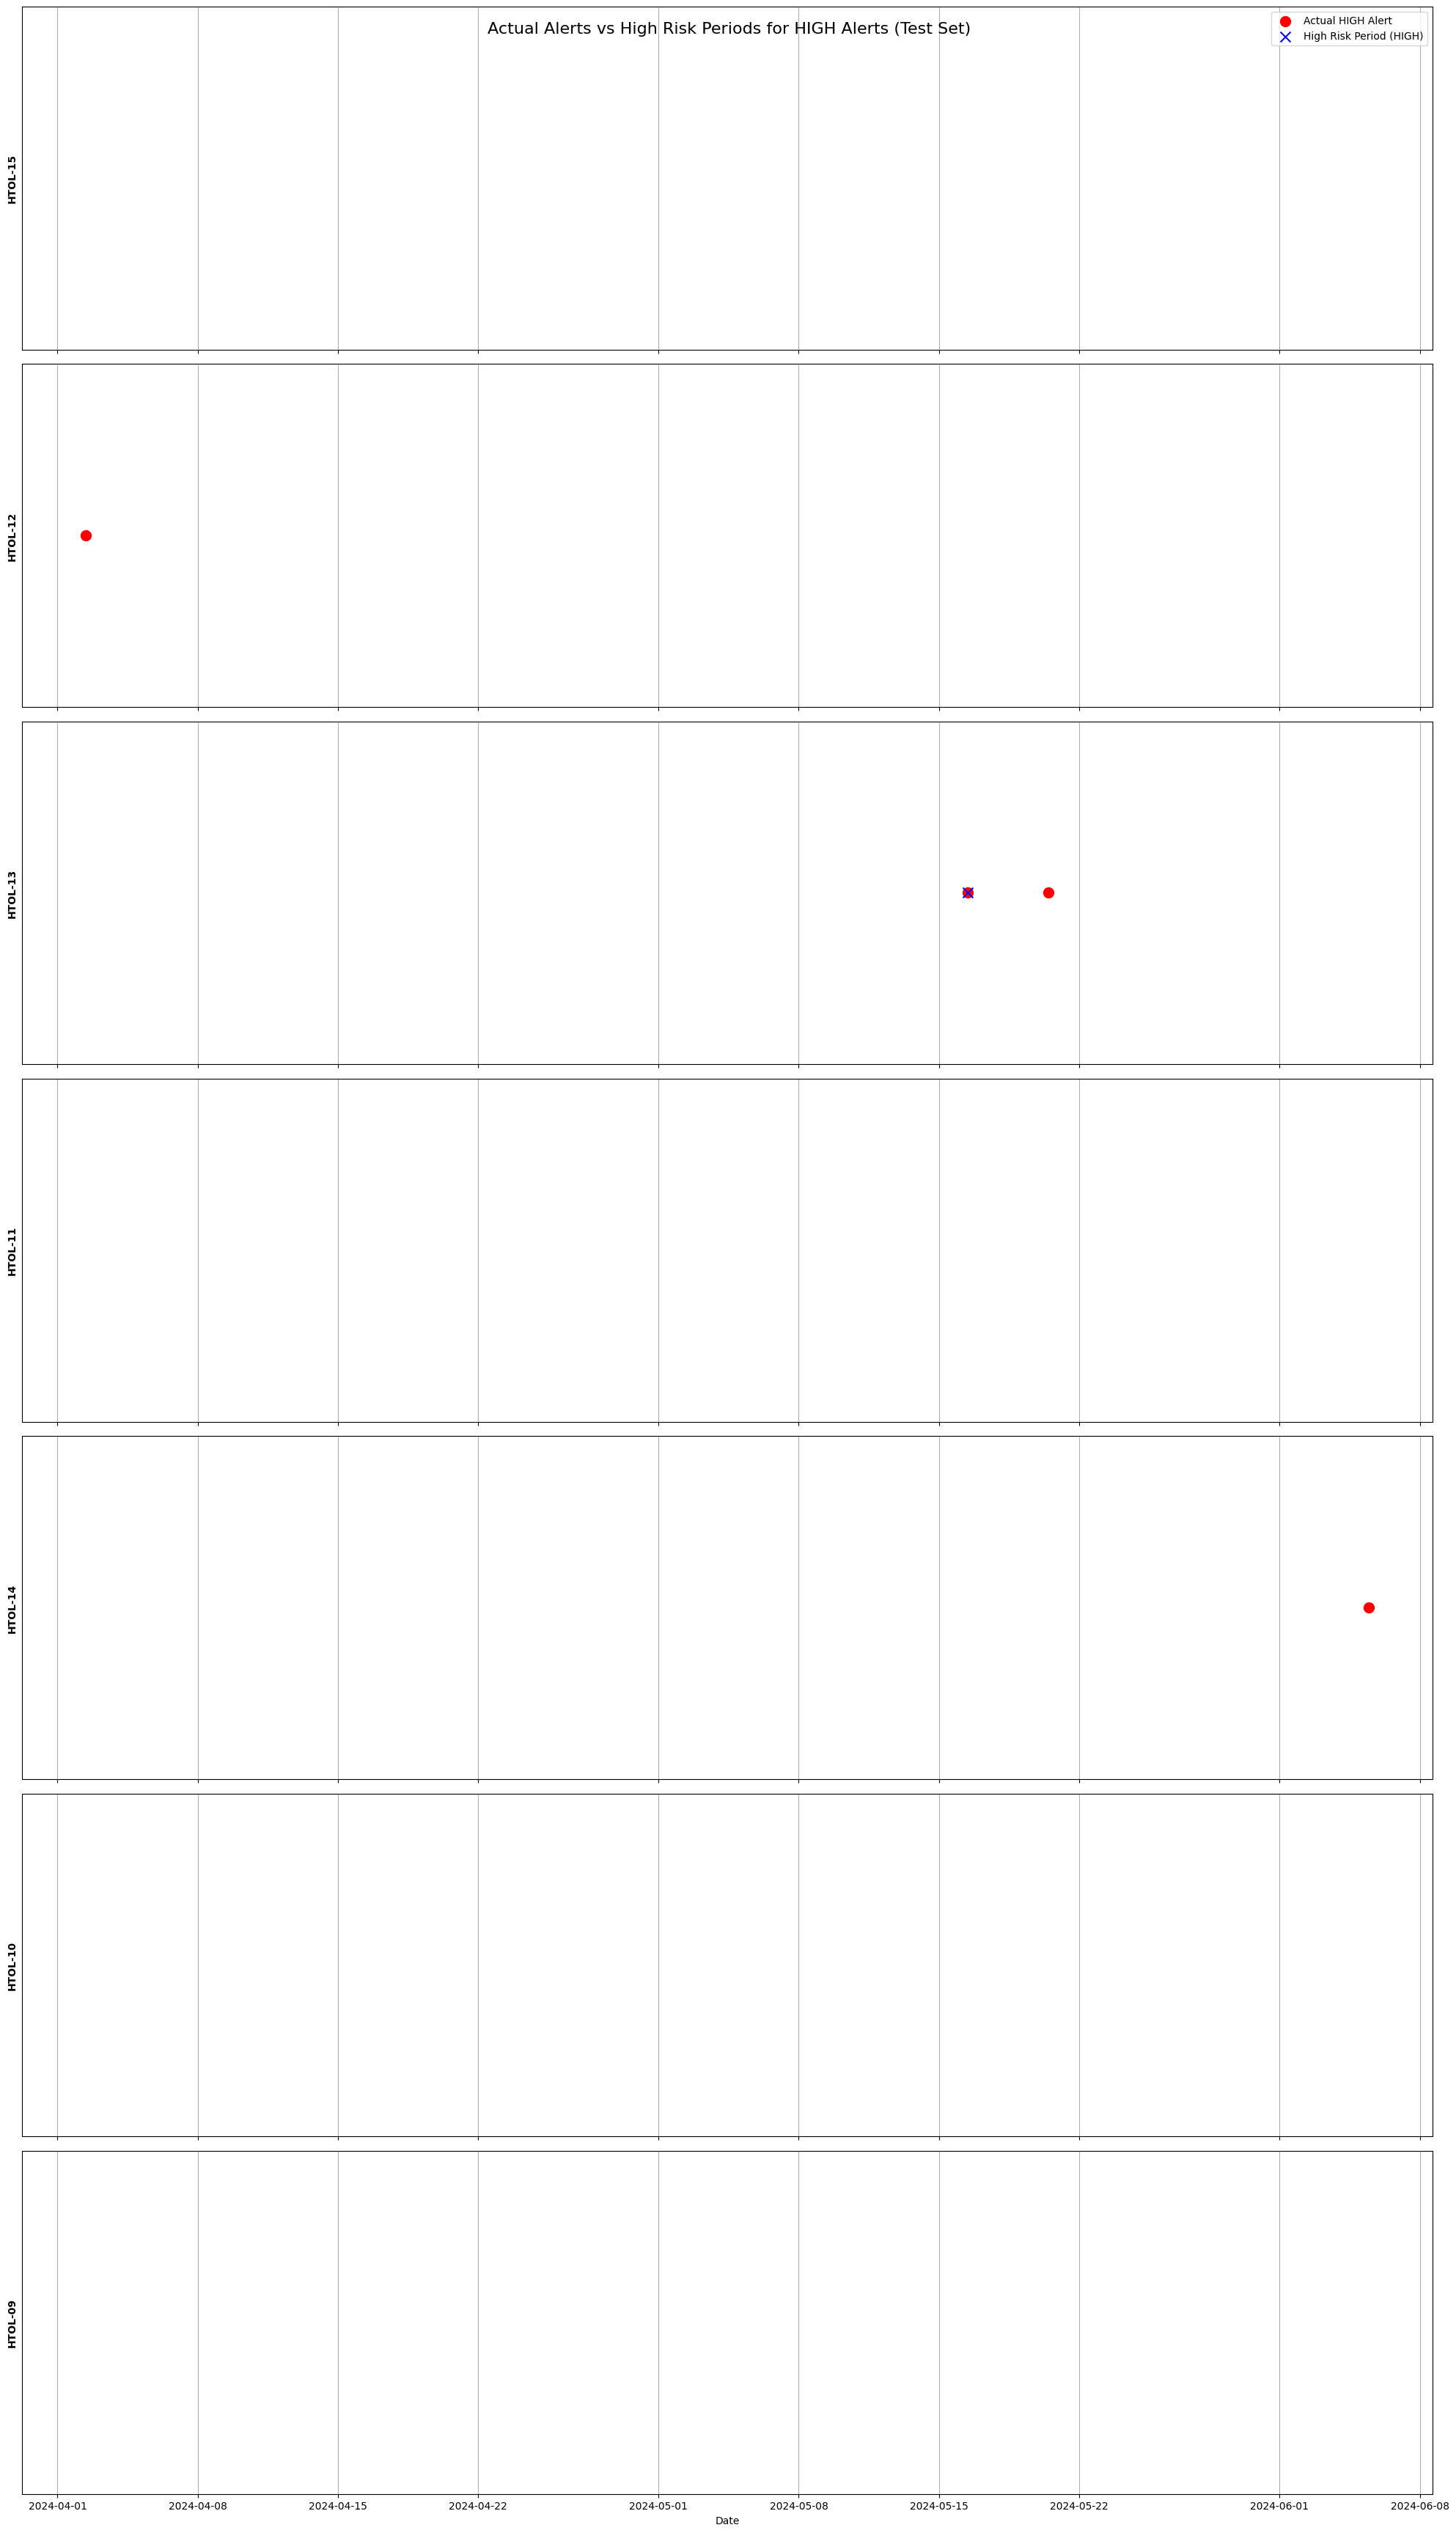


Training model for SIGMA alerts:


/var/folders/d7/0np89js16x9b596pzk8m108c0000gn/T/ipykernel_51561/3239783937.py:2: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['target'] = df.groupby('machine_id').apply(lambda x: (x['ALERT'] == target_alert_type).rolling(window=prediction_window).max().shift(-prediction_window+1)).reset_index(level=0, drop=True)


              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    531841
         1.0       1.00      0.10      0.18        40

    accuracy                           1.00    531881
   macro avg       1.00      0.55      0.59    531881
weighted avg       1.00      1.00      1.00    531881



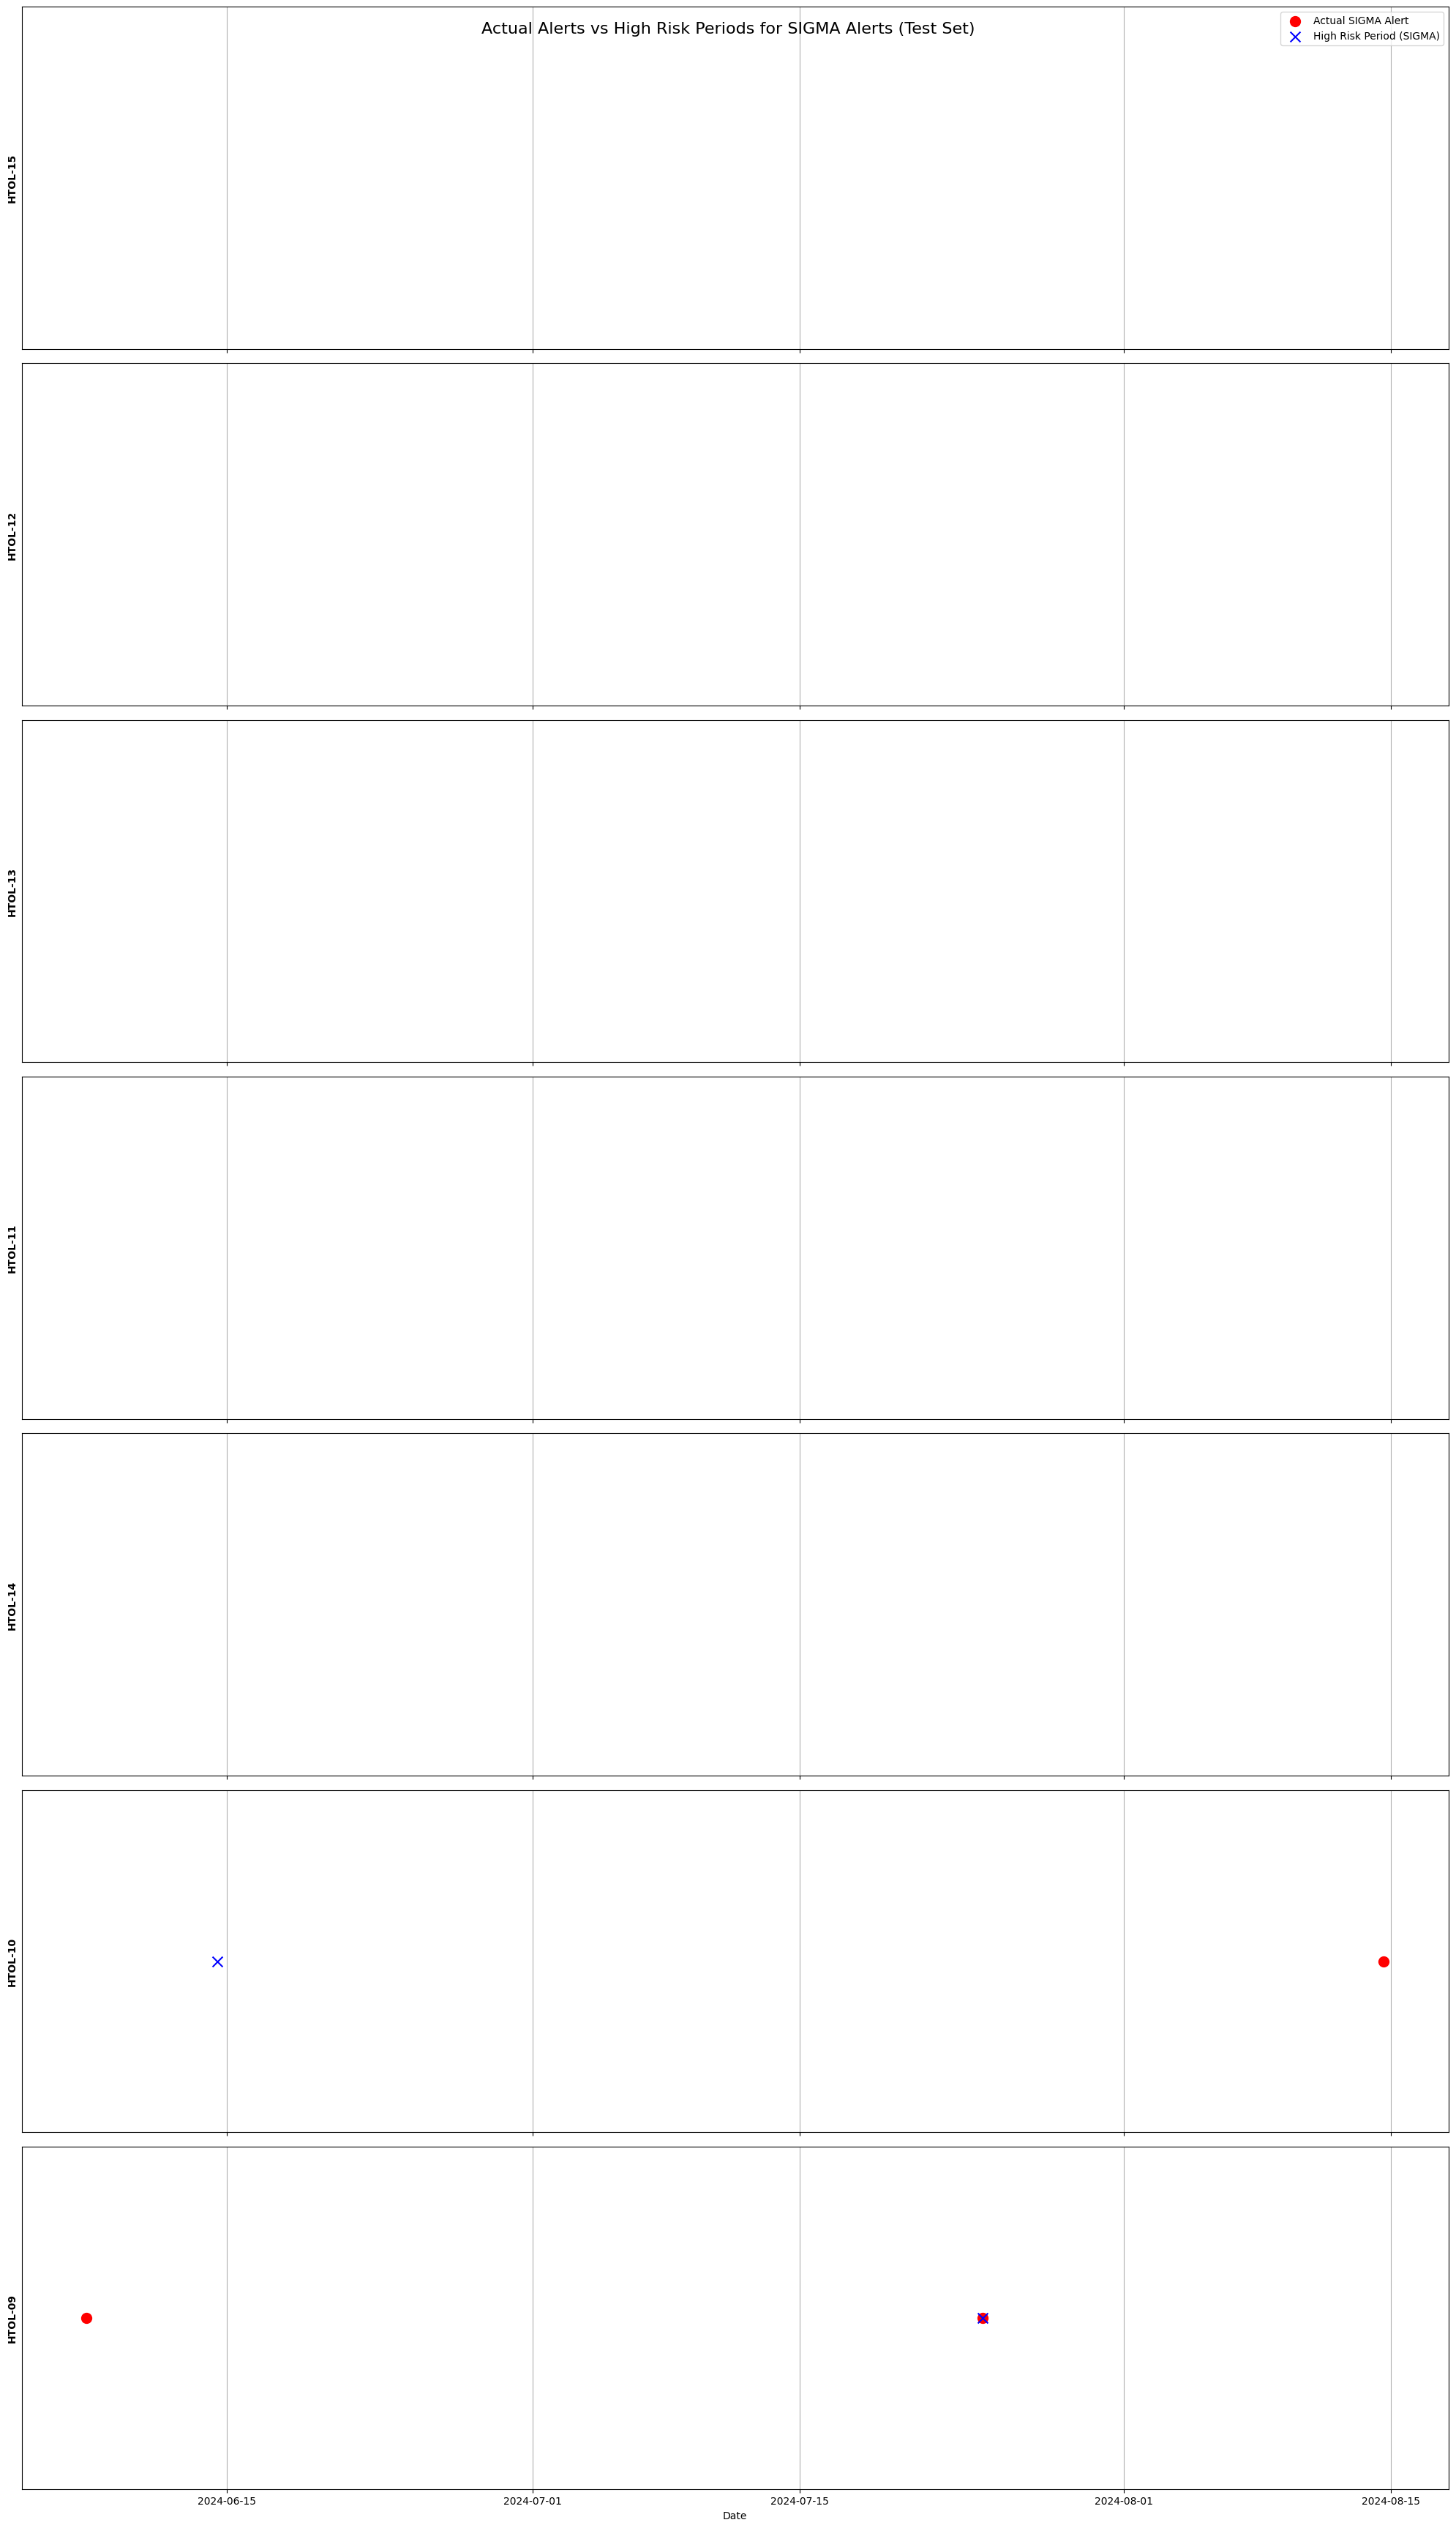

In [7]:
condition = True
# Main execution
if condition:
    folder = "../outlier_tolerance=5_grouping_time_window=200_anomaly_threshold=6_start_date=2022-01-01_end_date=2026-01-01"
    prediction_window = 7  # days
    probability_threshold = 0.7  # Adjust this value to balance between over-prediction and missed alerts

    df = load_and_preprocess_data(folder)
    df = engineer_features(df)

    alert_types = ['LOW', 'MEDIUM', 'HIGH', 'SIGMA']
    models = {}
    scalers = {}

    for alert_type in alert_types:
        print(f"\nTraining model for {alert_type} alerts:")
        X, y = prepare_data_for_classification(df, alert_type, prediction_window)

        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=42)

        model, scaler = train_and_evaluate_classifier(X_train, X_test, y_train, y_test)
        models[alert_type] = model
        scalers[alert_type] = scaler

        df_test = df.loc[y_test.index]
        visualize_alerts_test_set(df_test, model, scaler, alert_type, prediction_window, probability_threshold)

    # # Example of making predictions for new data
    # new_data = df.iloc[-1:].copy()  # Use the last row as an example
    # for alert_type in alert_types:
    #     features = ['ChlPrs', 'hour', 'day_of_week', 'month', 'is_weekend', 'rolling_mean', 'rolling_std'] + [f'time_since_{at}' for at in alert_types]
    #     X_new = new_data[features]
    #     X_new_scaled = scalers[alert_type].transform(X_new)
    #     alert_probability = models[alert_type].predict_proba(X_new_scaled)[0, 1]
    #     print(f"Probability of {alert_type} alert in the next {prediction_window} days: {alert_probability:.2f}")